# I decided to make a newer, cleaner notebook to make things easier to follow. I also added a training and test set to this notebook.


In [45]:
%matplotlib inline
import numpy as np
import pandas as pd
import scipy as sp
from scipy import stats
import sklearn
import seaborn as sns
import sklearn.cross_validation
from sklearn.ensemble import RandomForestClassifier
from sklearn.cross_validation import cross_val_score
from matplotlib import pyplot as plt
from mpl_toolkits.mplot3d import Axes3D
from sklearn import datasets
from sklearn import linear_model
from matplotlib import rcParams
import pickle
rcParams.update({'figure.autolayout': True})


# Variable to set to true if you want to rerun calculations that are random

In [111]:
#variable to set if you want to rerun non-deterministic statistics plots, like the RFCs
rerun = False
#rerun = True

In [47]:
#Read in all of the non-erupting data
url = 'Non_Eruption_Analysis_Updated_test.csv'
non_erupting = pd.read_csv(url)
non_erupting = non_erupting.drop('id', axis=1)
non_erupting.replace('Na',np.nan, inplace=True)
non_erupting['Eruption'] = 0
non_erupting.head()

,Track No.,avg_len,len_slope,len_stdev,len_skew,avg_area,area_slope,avg_chirality,area_stdev,area_skew,...,L_to_W_slope,L_to_W_stdev,L_to_W_skew,solar_region,avg_ar_dist,ar_dist_slope,ar_dist_stdev,ar_dist_skew,avg_ycen,Eruption
0,45,7564764370,16168.80581,6.168439e+09,1.640895,820.900541,0.002343,0.285714,711.119134,1.851593,...,1.280000e-06,0.283041,-0.430376,ML,358.304000,-0.000143,29.819788,-0.753765,617.737139,0
1,68,9570002684,859.07141,6.163937e+09,1.119408,3217.543074,-0.001206,-0.250000,3393.403973,1.796474,...,7.290000e-07,0.347411,0.350074,ML,356.505500,-0.000004,42.561513,0.499370,677.675873,0
2,146,9471339418,41986.89992,3.769297e+09,-0.849078,3268.798567,0.027267,0.400000,2051.688011,0.110602,...,1.760000e-06,0.257390,-0.478536,ML,259.205800,-0.000076,19.079967,-0.357808,-508.451807,0
3,160,9055175780,14375.33594,2.888129e+09,0.241333,866.382595,0.002529,-0.400000,430.713124,0.615826,...,-1.520000e-06,0.323137,0.539716,ML,274.555000,0.000421,49.609483,0.405530,386.710205,0
4,197,9291964133,10166.64569,2.303075e+09,-0.162335,1529.055734,-0.000229,0.500000,419.947129,0.119720,...,1.030000e-06,0.211130,-0.089955,ML,417.592667,-0.000798,159.630058,-0.155132,476.535838,0


In [48]:
#Read in all of the erupting data
url = 'Eruption_Analysis_Updated_test.csv'
#url = 'Eruption_Analysis_Updated.csv'
erupting = pd.read_csv(url)
erupting = erupting.drop('id', axis=1)
erupting.replace('Na',np.nan, inplace=True)
#erupting = erupting.astype(float)
erupting['Eruption'] = 1
#erupting = erupting.dropna()
erupting.head()

,Track No.,avg_len,len_slope,len_stdev,len_skew,avg_area,area_slope,avg_chirality,area_stdev,area_skew,...,L_to_W_slope,L_to_W_stdev,L_to_W_skew,solar_region,avg_ar_dist,ar_dist_slope,ar_dist_stdev,ar_dist_skew,avg_ycen,Eruption
0,15,10978146000,-13370.431360,6.072829e+09,1.319385,2072.790662,-0.002303,0.200000,1248.783467,0.267216,...,2.350000e-08,0.640376,-0.278408,ML,265.254000,-1.090000e-03,136.870729,1.231251,510.907599,1
1,57,18999056236,-18661.156780,6.805377e+09,-0.442429,5098.999213,-0.005713,0.142857,2077.915766,0.049522,...,3.560000e-07,0.210505,2.400850,ML,266.113929,-7.840000e-05,78.060976,-0.547179,298.202714,1
2,110,9949694431,2989.447284,4.907138e+09,0.348667,1706.056265,0.001813,-0.200000,1079.377133,0.479399,...,2.100000e-07,0.340379,0.109685,ML,306.609907,-2.814120e-04,107.732769,-0.774410,420.964402,1
3,144,9430329797,3529.134085,8.434491e+09,1.750261,2285.846427,-0.002171,0.142857,2423.039674,1.446848,...,1.660000e-06,0.433823,0.847777,ML,153.100000,6.330000e-05,64.623421,1.261523,-236.898713,1
4,171,5605677141,-1197.610778,1.730809e+09,1.120567,873.097034,0.000115,-0.375000,319.604775,1.613887,...,-2.680000e-07,0.353588,1.078732,ML,313.758625,-4.840000e-07,34.318661,0.578426,732.897369,1


In [49]:
#are our classes even?
print len(erupting)
print len(non_erupting)

126
141


In [50]:
#Here are some A-D results - Use them as you wish. 
#Could also do this with KS test results, but at the recent conference I went to, they specifically said how far behind astronomcers were in statistics, and how even using A-D instead of KS would be an improvemnet

ad_siglevel = []
ad_statistic = []
name_list = []
for item in erupting.keys():
    if item != 'Eruption':
        ad_stat = stats.anderson_ksamp([erupting[item].tolist(), non_erupting[item].tolist()])
        print item, ad_stat.statistic, ad_stat.significance_level
        ad_siglevel.append(ad_stat.significance_level)
        ad_statistic.append(ad_stat.statistic)
        name_list.append(item)
        
#ad_siglevel, name_list = zip(*sorted(zip(ad_siglevel, name_list)))      
ad_siglevel, ad_statistic, name_list = zip(*sorted(zip(ad_siglevel, ad_statistic, name_list)))  
i=0
print ''
print 'Sorted'

for item in name_list:
    print item, '%.2f' %ad_statistic[i], '%.5f'%ad_siglevel[i]
    i = i + 1

ad_siglevel_series = pd.Series(ad_siglevel, index=name_list)    
ad_stat_series = pd.Series(ad_statistic, index=name_list)    


Track No. 3.62619916431 0.0111681682556
avg_len -0.804276003996 0.816952317172
len_slope 15.3628879406 1.56330044223e-05
len_stdev -0.486792840195 0.581117452988
len_skew 4.2460381311 0.00663072595432
avg_area -0.578212740001 0.640670045457
area_slope 8.16132902544 0.00038584273172
avg_chirality 0.882784460836 0.141737861752
area_stdev -0.0770435234617 0.377235725538
area_skew 0.628071675267 0.182949067555
chirality_slope 0.374294480492 0.23669277595
avg_decay_index -0.526293917303 0.606106588259
decay_index_slope 1.44704283114 0.0814726850878
avg_barbs -0.456383197224 0.562614112563
barb_slope 5.97615445136 0.0017148712683
barb_stdev 0.19712698273 0.283865147706
barb_skew -0.682444737868 0.716418828728
avg_tilt -0.301940339009 0.47769547028
tilt_slope -0.533151635222 0.61055802142
tilt_stdev -0.525109884899 0.605341455452
tilt_skew -0.841822485675 0.850820823722
avg_L_to_W -0.21489594864 0.435845661651
L_to_W_slope 3.54590098614 0.0119655224677
L_to_W_stdev 1.55916385096 0.07312430645

## Now let's set ourselves up for the random forest

In [51]:
all_eruptions=erupting.append(non_erupting)   #adding everything together
all_eruptions.reset_index(inplace=True)  
#all_eruptions = all_eruptions.dropna() #for now, dropping everything with NaN
all_eruptions.head()

,index,Track No.,avg_len,len_slope,len_stdev,len_skew,avg_area,area_slope,avg_chirality,area_stdev,...,L_to_W_slope,L_to_W_stdev,L_to_W_skew,solar_region,avg_ar_dist,ar_dist_slope,ar_dist_stdev,ar_dist_skew,avg_ycen,Eruption
0,0,15,10978146000,-13370.431360,6.072829e+09,1.319385,2072.790662,-0.002303,0.200000,1248.783467,...,2.350000e-08,0.640376,-0.278408,ML,265.254000,-1.090000e-03,136.870729,1.231251,510.907599,1
1,1,57,18999056236,-18661.156780,6.805377e+09,-0.442429,5098.999213,-0.005713,0.142857,2077.915766,...,3.560000e-07,0.210505,2.400850,ML,266.113929,-7.840000e-05,78.060976,-0.547179,298.202714,1
2,2,110,9949694431,2989.447284,4.907138e+09,0.348667,1706.056265,0.001813,-0.200000,1079.377133,...,2.100000e-07,0.340379,0.109685,ML,306.609907,-2.814120e-04,107.732769,-0.774410,420.964402,1
3,3,144,9430329797,3529.134085,8.434491e+09,1.750261,2285.846427,-0.002171,0.142857,2423.039674,...,1.660000e-06,0.433823,0.847777,ML,153.100000,6.330000e-05,64.623421,1.261523,-236.898713,1
4,4,171,5605677141,-1197.610778,1.730809e+09,1.120567,873.097034,0.000115,-0.375000,319.604775,...,-2.680000e-07,0.353588,1.078732,ML,313.758625,-4.840000e-07,34.318661,0.578426,732.897369,1


In [52]:
all_eruptions.describe()

,index,Track No.,avg_len,len_slope,len_stdev,len_skew,avg_area,area_slope,avg_chirality,area_stdev,...,avg_L_to_W,L_to_W_slope,L_to_W_stdev,L_to_W_skew,avg_ar_dist,ar_dist_slope,ar_dist_stdev,ar_dist_skew,avg_ycen,Eruption
count,267.000000,267.000000,2.670000e+02,267.000000,2.670000e+02,267.000000,267.000000,267.000000,267.000000,267.000000,...,267.000000,2.670000e+02,267.000000,267.000000,267.000000,267.000000,267.000000,267.000000,267.000000,267.000000
mean,66.460674,2715.082397,9.209876e+09,9433.398203,4.432831e+09,0.368057,1490.475821,0.002153,-0.014402,872.996595,...,1.195053,6.739431e-07,0.330547,0.245289,360.252732,-0.000147,80.528023,0.117291,-22.515247,0.471910
std,38.972727,1855.295234,4.725092e+09,27429.751936,3.206008e+09,0.704966,1282.681147,0.006583,0.284102,915.358903,...,0.459761,2.617490e-06,0.211608,0.626052,211.426482,0.000783,70.196589,0.735576,421.866312,0.500148
min,0.000000,15.000000,2.744535e+09,-79948.004700,1.978078e+08,-1.149596,214.994254,-0.021197,-0.750000,6.096202,...,0.323825,-1.550000e-05,0.046171,-1.481770,42.815870,-0.006829,4.706213,-1.887182,-890.119751,0.000000
25%,33.000000,1256.500000,5.833879e+09,-5588.982832,2.266309e+09,-0.095721,675.715257,-0.000738,-0.200000,319.871939,...,0.862979,-3.730000e-07,0.174296,-0.133511,185.737625,-0.000358,35.029183,-0.383740,-424.662887,0.000000
50%,66.000000,2309.000000,8.084125e+09,5523.965186,3.590844e+09,0.362257,1099.530106,0.000907,0.000000,565.375914,...,1.161542,6.870000e-07,0.285519,0.242846,320.938250,-0.000069,57.594292,0.138865,50.249439,0.000000
75%,99.500000,4447.500000,1.121313e+10,18206.905640,5.724696e+09,0.881728,1837.401145,0.003644,0.200000,1110.227613,...,1.491678,1.650000e-06,0.446801,0.624247,491.585000,0.000196,96.807609,0.617187,338.733189,1.000000
max,140.000000,6412.000000,2.868310e+10,135635.191600,1.959616e+10,2.167071,9416.620839,0.040278,0.666667,6551.492723,...,2.777159,1.030000e-05,1.276675,2.400850,995.278600,0.001771,415.654677,2.387121,793.357498,1.000000


In [53]:
print all_eruptions.columns

Index([u'index', u'Track No.', u'avg_len', u'len_slope', u'len_stdev',
       u'len_skew', u'avg_area', u'area_slope', u'avg_chirality',
       u'area_stdev', u'area_skew', u'chirality_slope', u'avg_decay_index',
       u'decay_index_slope', u'avg_barbs', u'barb_slope', u'barb_stdev',
       u'barb_skew', u'avg_tilt', u'tilt_slope', u'tilt_stdev', u'tilt_skew',
       u'avg_L_to_W', u'L_to_W_slope', u'L_to_W_stdev', u'L_to_W_skew',
       u'solar_region', u'avg_ar_dist', u'ar_dist_slope', u'ar_dist_stdev',
       u'ar_dist_skew', u'avg_ycen', u'Eruption'],
      dtype='object')


In [54]:
#The random forest does a better job with values near 0 in general
#So here I am going to standardize all of the values so they are between 0 and 1
def standardize(column):
    new_column = (all_eruptions[column]-min(all_eruptions[column]))/(max(all_eruptions[column])-min(all_eruptions[column]))
    all_eruptions[column] = new_column

all_columns = ['avg_len', 'len_slope', 'len_stdev',
       'len_skew', 'avg_area', 'area_slope', 'avg_chirality',
       'area_stdev', 'area_skew', 'chirality_slope', 'avg_decay_index',
       'decay_index_slope', 'avg_barbs', 'barb_slope', 'barb_stdev',
       'barb_skew', 'avg_tilt', 'tilt_slope', 'tilt_stdev', 'tilt_skew',
       'avg_L_to_W', 'L_to_W_slope', 'L_to_W_stdev', 'L_to_W_skew',
       'avg_ar_dist', 'ar_dist_slope', 'ar_dist_stdev',
       'ar_dist_skew']
for each in all_columns:
    standardize(each)

all_eruptions.describe()

,index,Track No.,avg_len,len_slope,len_stdev,len_skew,avg_area,area_slope,avg_chirality,area_stdev,...,avg_L_to_W,L_to_W_slope,L_to_W_stdev,L_to_W_skew,avg_ar_dist,ar_dist_slope,ar_dist_stdev,ar_dist_skew,avg_ycen,Eruption
count,267.000000,267.000000,267.000000,267.000000,267.000000,267.000000,267.000000,267.000000,267.000000,267.000000,...,267.000000,267.000000,267.000000,267.000000,267.000000,267.000000,267.000000,267.000000,267.000000,267.000000
mean,66.460674,2715.082397,0.249256,0.414603,0.218319,0.457584,0.138615,0.379830,0.519246,0.132444,...,0.355120,0.626897,0.231105,0.444818,0.333280,0.776915,0.184504,0.468959,-22.515247,0.471910
std,38.972727,1855.295234,0.182165,0.127235,0.165272,0.212553,0.139397,0.107080,0.200542,0.139848,...,0.187402,0.101453,0.171968,0.161245,0.221979,0.091068,0.170816,0.172093,421.866312,0.500148
min,0.000000,15.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,...,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,-890.119751,0.000000
25%,33.000000,1256.500000,0.119102,0.344920,0.106633,0.317751,0.050070,0.332803,0.388235,0.047938,...,0.219764,0.586318,0.104124,0.347255,0.150055,0.752446,0.073788,0.351740,-424.662887,0.000000
50%,66.000000,2309.000000,0.205855,0.396469,0.174914,0.455835,0.096128,0.359552,0.529412,0.085446,...,0.341461,0.627403,0.194512,0.444189,0.292003,0.786063,0.128698,0.474006,50.249439,0.000000
75%,99.500000,4447.500000,0.326487,0.455299,0.284915,0.612459,0.176317,0.404078,0.670588,0.168688,...,0.476027,0.664729,0.325582,0.542422,0.471167,0.816901,0.224119,0.585913,338.733189,1.000000
max,140.000000,6412.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,...,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,793.357498,1.000000


In [55]:
#Pull out the feature we want to predict (1 for eruption, 0 for no eruption)
Y = np.array(all_eruptions['Eruption'])  #getting the eruption status (variable that is trying to be predicted)

In [56]:
#Now we need to remove that from our dataset. 
all_eruptions = all_eruptions.drop('Eruption',1)  #now dropping the eruption column! 
region = all_eruptions['solar_region']
all_eruptions = all_eruptions.drop('solar_region',1) #drop solar_region too. It can't use strings

In [57]:
#Now we need to save all of the features as a matrix for the calucations later
print all_eruptions.columns
X = all_eruptions.as_matrix()

Index([u'index', u'Track No.', u'avg_len', u'len_slope', u'len_stdev',
       u'len_skew', u'avg_area', u'area_slope', u'avg_chirality',
       u'area_stdev', u'area_skew', u'chirality_slope', u'avg_decay_index',
       u'decay_index_slope', u'avg_barbs', u'barb_slope', u'barb_stdev',
       u'barb_skew', u'avg_tilt', u'tilt_slope', u'tilt_stdev', u'tilt_skew',
       u'avg_L_to_W', u'L_to_W_slope', u'L_to_W_stdev', u'L_to_W_skew',
       u'avg_ar_dist', u'ar_dist_slope', u'ar_dist_stdev', u'ar_dist_skew',
       u'avg_ycen'],
      dtype='object')


## Split stuff up into training and test data (this is new)

In [58]:
#Can split up the data to make a test dataset.
#The test data will not go into the random forest at all. Then once we make our forest, we can try it on our test data to see how it does
#This can be useful to test how things like feature selection affect the outcome
#Just have these handy. For the most part, it is not necessary because of the bootstrap method of the regular random forest. 
from sklearn.cross_validation import train_test_split

if rerun:
    train_X, test_X, train_Y, test_Y = train_test_split(X, Y,  test_size=0.33, random_state=12)
    print train_X.shape, test_X.shape, train_Y.shape, test_Y.shape

(178, 31) (89, 31) (178,) (89,)


In [59]:
non_erupt = 0.
for eruption in Y:
    if eruption == 0:
        non_erupt = non_erupt+1.
avg = non_erupt/len(Y)
print avg
print '%d percent of filaments do NOT erupt. Our sample is not quite balanced, but pretty close' % (avg*100)

0.52808988764
52 percent of filaments do NOT erupt. Our sample is not quite balanced, but pretty close


In [60]:
n_erupt = len(erupting)
n_no_erupt = len(non_erupting)

total = n_erupt+n_no_erupt
#guess randomly, with a 50/50 chance of guessing erupting/non-erupting
TP = 0.5*(n_erupt/float(total))
FP = 0.5*(n_erupt/float(total))
FN = 0.5*(n_no_erupt/float(total))
TN = 0.5*(n_no_erupt/float(total))
precision = TP/(TP+FP)
recall = TP/(TP+FN)
F1_random = 2*precision*recall/(precision+recall)
print "F1 random guess"
print precision
print recall
print F1_random

#Always guess non_eruption
TP = n_no_erupt/float(total)
FP = n_erupt/float(total)
FN = 0
TN = 0
precision = TP/(TP+FP)
recall = TP/(TP+FN)
F1_non = 2*precision*recall/(precision+recall)
print "F1 guess non-eruption"
print precision
print recall
print F1_non



F1 random guess
0.5
0.47191011236
0.485549132948
F1 guess non-eruption
0.52808988764
1.0
0.691176470588


In [62]:
#Let's start by making 40 different 'forests' (based on decision trees)
from sklearn.ensemble import RandomForestClassifier
from sklearn.cross_validation import cross_val_score
from sklearn.cross_validation import StratifiedKFold
#n_trees = range(1,41)
if rerun:
    scores_range = []
    data_subsets = 10
    #This will make 40 forests, and each forest will be made up of increasing numbers (1-40) of trees
    #This way, we can see how much of an effect adding more trees has on the predictions.
    for i in range(1,41):
        #n_estimators - the number of trees in the forest
        #max_depth - how many branches on the tree. I added this keyword per Rafal's suggestion. We can play around with different depths.
        forest = sklearn.ensemble.RandomForestClassifier(n_estimators = i, max_depth=5,warm_start=True)
        #val_score = cross_val_score(forest, X=X, y=Y, cv=10)
        val_score = cross_val_score(forest, X, Y, cv=StratifiedKFold(Y,data_subsets, shuffle=True),
                                   scoring='f1') #Try out a new type of scoring
        scores_range.append(val_score) 

    pickle.dump(scores_range, open( "RFC_nestimators_test_scores.p", "wb" ) )    

0.609766849454
<type 'list'>


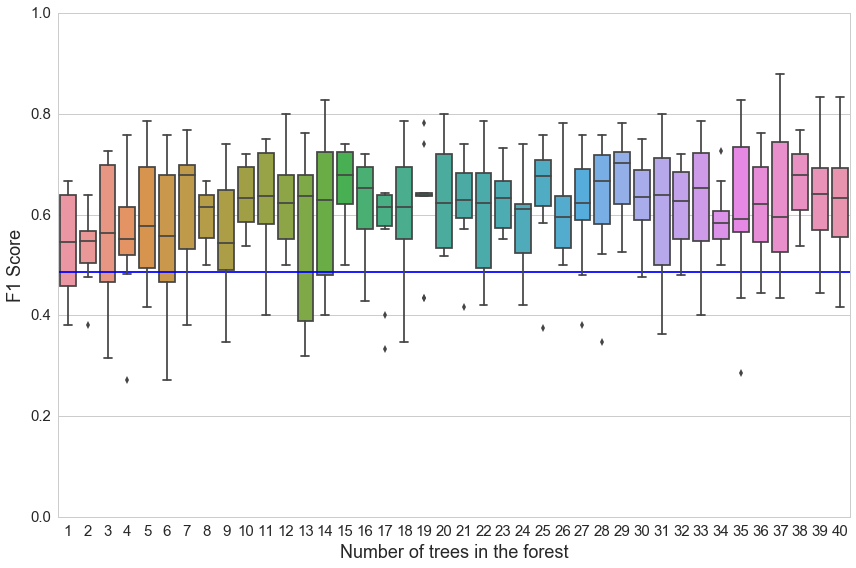

In [112]:
#How good at prediction is my tree? (I ran 40 different tests, so each bar is one test).

if not rerun:
    scores_range = pickle.load( open( "RFC_nestimators_test_scores.p", "rb" ) )

print np.mean(scores_range)
from matplotlib import pyplot as plt
orig_labels = range(1,41)
test_labels = range(1,201,5)
plt.figure(figsize=(12,8))
#plt.title('Effect of the number of trees on predictions', fontsize=20)
plt.xlabel('Number of trees in the forest', fontsize=18)
plt.ylabel('F1 Score', fontsize=18)
plt.ylim(ymax = 1, ymin = 0)
plt.axhline(y=F1_random)
plt.tick_params(axis='both', which='major', labelsize=15)   
sns.set_style("whitegrid")
ax=sns.boxplot(x=orig_labels,y=scores_range)
#plt.savefig('/Users/nschanch/Desktop/REU_2015/ipython_figures/forests_with_1_to_40_trees.png')
#sns.boxplot(scores) #NOTE: Use this line if you have the older version of seaborn!!
#plt.savefig("/home/nschanch/Downloads/test_img.png")
#Note: This is before correcting for the unbalanced sample size. 
print type(scores_range)
plt.savefig('/storage/kreeves/Projects/REU/reu2015/final/Filament_tracking/RFC_number_trees_boxplot.eps')
plt.savefig('/storage/kreeves/Projects/REU/reu2015/final/Filament_tracking/RFC_number_trees_boxplot.pdf')

In [64]:
scores_range[0]

array([ 0.4516129 ,  0.53846154,  0.55172414,  0.64      ,  0.38095238,
        0.47619048,  0.41666667,  0.66666667,  0.66666667,  0.63636364])

0.615384615385


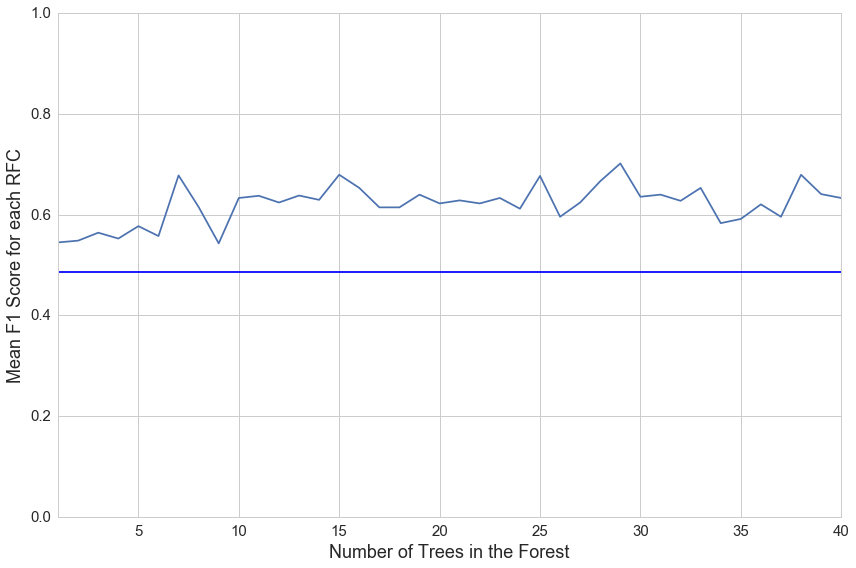

In [113]:
print np.median(scores_range)
mean_scores = []
runs = range(1,41)
for i in runs:
    mean_scores.append(np.median(scores_range[i-1]))

plt.figure(figsize=(12,8))
plt.ylabel('Mean F1 Score for each RFC',fontsize=18)
plt.xlabel('Number of Trees in the Forest',fontsize=18)
plt.axhline(y=F1_random)
plt.plot(runs,mean_scores)
plt.ylim(ymax = 1, ymin = 0)
plt.xlim(xmax = 40, xmin = 1)
plt.tick_params(axis='both', which='major', labelsize=15)   
plt.show()

In [66]:

from sklearn.ensemble import RandomForestClassifier
from sklearn.cross_validation import cross_val_score

if rerun:
    #Unlike above, now we want to make 40 different forests, each conaining 25 trees, but with varying depths)
    depths = range(1,21)
    scores = []
    #This will make 25 forests, and each forest will have depths ranging from 1-25 successively
    #This way, we can see how much of an effect adding more trees has on the predictions.
    for i in depths:
        forest = sklearn.ensemble.RandomForestClassifier(n_estimators = 25, max_depth=i)
        val_score = cross_val_score(forest, X, Y, cv=StratifiedKFold(Y,10, shuffle=True),scoring='f1')
        #val_score = cross_val_score(forest, X=X, y=Y, cv=10)
        scores.append(val_score) 
        
        pickle.dump(scores, open( "RFC_depth_test_scores.p", "wb" ) )    

0.613824244169


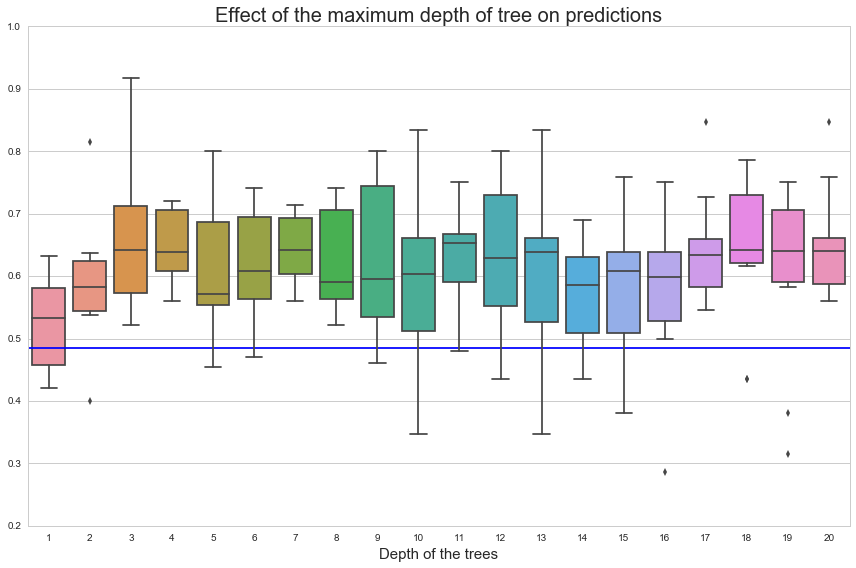

In [108]:
if not rerun:
    scores = pickle.load( open( "RFC_depth_test_scores.p", "rb" ) )

print np.mean(scores)
from matplotlib import pyplot as plt
orig_labels = range(20)
test_labels = range(1,21)
plt.figure(figsize=(12,8))
plt.title('Effect of the maximum depth of tree on predictions', fontsize=20)
plt.xlabel('Depth of the trees', fontsize=15)
plt.axhline(y=F1_random)
sns.boxplot(x=test_labels,y=scores)
#plt.savefig('/Users/nschanch/Desktop/REU_2015/ipython_figures/forests_deepening_trees.png')


## Here are some exploratory plots

,index,Track No.,avg_len,len_slope,len_stdev,len_skew,avg_area,area_slope,avg_chirality,area_stdev,...,tilt_skew,avg_L_to_W,L_to_W_slope,L_to_W_stdev,L_to_W_skew,avg_ar_dist,ar_dist_slope,ar_dist_stdev,ar_dist_skew,avg_ycen
0,0,15,0.317427,0.308825,0.302862,0.744416,0.201899,0.307345,0.670588,0.189857,...,0.468714,0.409949,0.601686,0.482895,0.309936,0.233540,0.667320,0.321608,0.729577,510.907599
1,1,57,0.626655,0.284284,0.340625,0.213216,0.530776,0.251862,0.630252,0.316531,...,0.341353,0.083935,0.614574,0.133551,1.000000,0.234443,0.784946,0.178501,0.313502,298.202714
2,2,110,0.277778,0.384712,0.242770,0.451738,0.162043,0.374298,0.388235,0.163975,...,0.679438,0.473493,0.608915,0.239095,0.409892,0.276960,0.761341,0.250704,0.260340,420.964402
3,3,144,0.257755,0.387215,0.424607,0.874328,0.225053,0.309490,0.630252,0.369259,...,0.559341,0.345237,0.665116,0.315035,0.599994,0.115788,0.801423,0.145802,0.736659,-236.898713
4,4,171,0.110305,0.365290,0.079027,0.684471,0.071520,0.346669,0.264706,0.047898,...,0.890080,0.221468,0.590388,0.249830,0.659478,0.284465,0.794006,0.072059,0.576845,732.897369


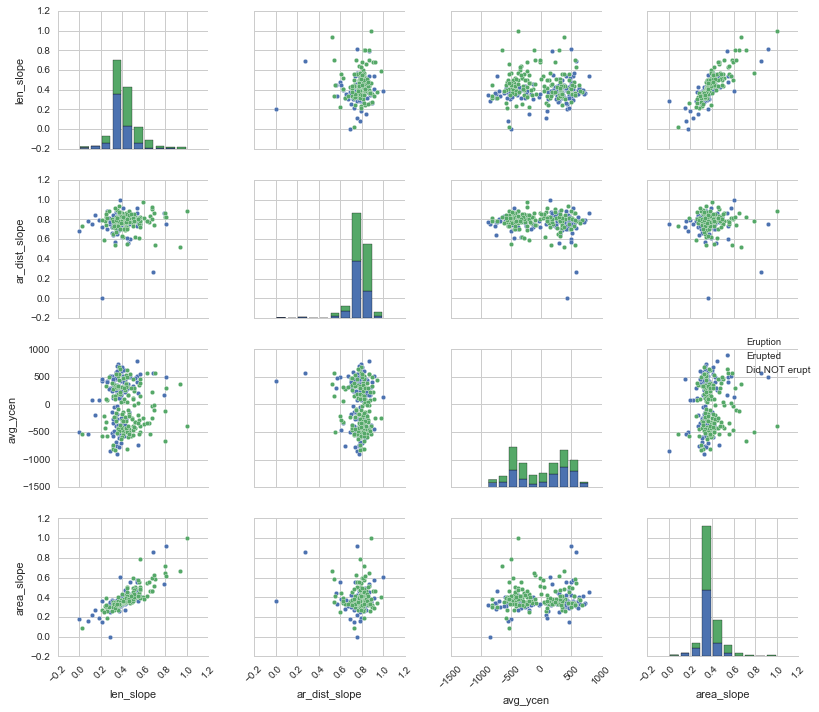

In [68]:
#all_eruptions2 = all_eruptions
Y_strings = Y.astype(str)

Y_strings[Y_strings == '1'] = 'Erupted'
Y_strings[Y_strings == '0'] = 'Did NOT erupt'

all_eruptions['Eruption'] = Y_strings #Have to add this back in


#You can change the features you want to compare. I just picked a few for demonstration purposes. 
g = sns.pairplot(all_eruptions[["len_slope", "ar_dist_slope", "avg_ycen", "area_slope","Eruption"]], hue='Eruption', diag_kind="hist")  

for ax in g.axes.flat:  
    plt.setp(ax.get_xticklabels(), rotation=45)
all_eruptions = all_eruptions.drop('Eruption',1)
all_eruptions.head()

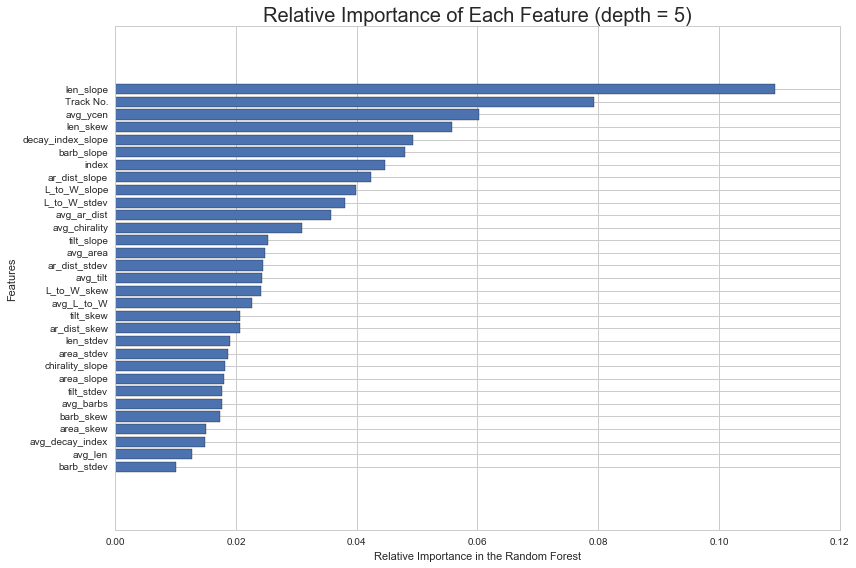

In [69]:
#Which features are most useful for prediction?
#I am using the entire forest from above to find the feature importance.
single_forest = sklearn.ensemble.RandomForestClassifier(n_estimators = 25, max_depth=5) #limit the 'depth' of the dicision tree (only split 5 times per tree)
#clf = RandomForestClassifier(n_estimators=25, max_depth=5) #Also make a single random forest with 25 trees and test that. 
name_list = all_eruptions.columns
#def plot_feature_importance(classifier, name_list, depth):
    #clf = RandomForestClassifier(n_estimators=15)
    #clf.fit(X_2,Y)
single_forest.fit(X, Y)
importance_list = single_forest.feature_importances_
#name_list = good_eruptions.columns
importance_list, name_list = zip(*sorted(zip(importance_list, name_list)))
plt.figure(figsize=(12,8))
plt.barh(range(len(name_list)),importance_list,align='center')
plt.yticks(range(len(name_list)),name_list)
plt.xlabel('Relative Importance in the Random Forest')
plt.ylabel('Features')
plt.title('Relative Importance of Each Feature (depth = 5)',fontsize=20)
    #plt.savefig('/Users/nschanch/Desktop/REU_2015/ipython_figures/feature_importances_limited.png')
plt.show()
    #plt.savefig('/Users/nschanch/Desktop/REU_2015/ipython_figures/feature_importances_limited.png')


In [70]:
#OK, let's get rid of some of the junk in the original dataset.

#Nicole's original.  Why these?
#good_eruptions = all_eruptions.drop(['Track No.', 'avg_barbs', 'avg_area','avg_len','len_stdev','L_to_W_slope','avg_chirality'], 1)
good_eruptions = all_eruptions.drop(['Track No.', 'index'], 1)

In [71]:
X_2 = good_eruptions.as_matrix()

In [73]:
#Repeat the feature importance with the smaller list of features
#Run 1000 times to get statistics on importances

#want also to include stuff for confusion matrix in same forest runs
from sklearn.cross_validation import train_test_split
from __future__ import division

name_list = good_eruptions.columns

scores_range = []
data_subsets = 10  #for F1 score

#variables for confusion matrix
TP_array = []
FP_array = []
FN_array = []
TN_array = []
accuracy_array = []

runs = range(1,1001)
if rerun:
    for i in runs:
        #create the forest
        #limit the 'depth' of the dicision tree (only split 5 times per tree)
        single_forest = sklearn.ensemble.RandomForestClassifier(n_estimators = 25, max_depth=5) 

        #compute F1 scores
        val_score = cross_val_score(single_forest, X_2, Y, cv=StratifiedKFold(Y,data_subsets, shuffle=True),
                                   scoring = 'f1')
        scores_range.append(val_score) 
    
        #calculate importances
        single_forest.fit(X_2, Y)
        importance_list = single_forest.feature_importances_
        importances_temp = pd.DataFrame({i : pd.Series(importance_list, index=name_list)})
        if i == 1:       
            importances = importances_temp
        else:
            importances[i] = importances_temp

        # Make confusion matrix
        # Fit the training data to the Survived labels and create the decision trees

        X_train,X_test,y_train,y_test = train_test_split(X_2,Y,test_size=0.4)
        confusion = single_forest.fit(X_train,y_train)

        # Take the same decision trees and run it on the test data
        y_pred = confusion.predict(X_test)

        cf_matrix=sklearn.metrics.confusion_matrix(y_test, y_pred, labels=None)
        TP=cf_matrix[0,0]
        FP=cf_matrix[1,0]
        FN=cf_matrix[0,1]
        TN=cf_matrix[1,1]
        rfc_accuracy = (TP+TN)/(TP+FN+FP+TN)
    
        TP_array.append(TP)
        FP_array.append(FP)
        FN_array.append(FN)
        TN_array.append(TN)
        accuracy_array.append(rfc_accuracy) 
    
    avg_importance = []
    for item in name_list:
        imp_list = importances.loc[item]
        avg_importance.append(np.mean(imp_list))
    
    avg_imp_df = pd.DataFrame({'mean' : pd.Series(avg_importance, index=name_list)})
    importances['mean'] = avg_imp_df

    print importances['mean']
    print np.mean(accuracy_array)
    
    pickle.dump(scores_range, open( "RFC_1000_runs_scores.p", "wb" ) ) 
    pickle.dump(importance_list, open( "RFC_1000_runs_importance_last.p", "wb" ) ) 
    pickle.dump(importances, open( "RFC_1000_runs_importances.p", "wb" ) ) 
    pickle.dump(TP_array, open( "RFC_1000_runs_TP.p", "wb" ) ) 
    pickle.dump(FP_array, open( "RFC_1000_runs_FP.p", "wb" ) ) 
    pickle.dump(FN_array, open( "RFC_1000_runs_FN.p", "wb" ) ) 
    pickle.dump(TN_array, open( "RFC_1000_runs_TN.p", "wb" ) ) 
    pickle.dump(accuracy_array, open( "RFC_1000_runs_accuracy.p", "wb" ) ) 

avg_len              0.018662
len_slope            0.100784
len_stdev            0.023408
len_skew             0.052281
avg_area             0.025199
area_slope           0.050494
avg_chirality        0.028660
area_stdev           0.030426
area_skew            0.027426
chirality_slope      0.042309
avg_decay_index      0.024546
decay_index_slope    0.041461
avg_barbs            0.019719
barb_slope           0.046758
barb_stdev           0.021553
barb_skew            0.019451
avg_tilt             0.026774
tilt_slope           0.024958
tilt_stdev           0.023182
tilt_skew            0.025349
avg_L_to_W           0.028949
L_to_W_slope         0.041621
L_to_W_stdev         0.034446
L_to_W_skew          0.028903
avg_ar_dist          0.037178
ar_dist_slope        0.046351
ar_dist_stdev        0.025000
ar_dist_skew         0.034760
avg_ycen             0.049395
Name: mean, dtype: float64
0.601822429907


In [74]:
from sklearn.cross_validation import cross_val_predict
single_forest = sklearn.ensemble.RandomForestClassifier(n_estimators = 25, max_depth=5) 
F1_score = cross_val_score(single_forest, X_2, Y, cv=StratifiedKFold(Y,data_subsets, shuffle=True),scoring='f1')
accuracy_score = cross_val_score(single_forest, X_2, Y, cv=StratifiedKFold(Y,data_subsets, shuffle=True),scoring='accuracy')

ffit = single_forest.fit(X_2, Y)
params = single_forest.get_params()
score = single_forest.score(X_2,Y)
print np.mean(F1_score)
print np.mean(accuracy_score)

0.553609391885
0.637067562068


0.592592592593


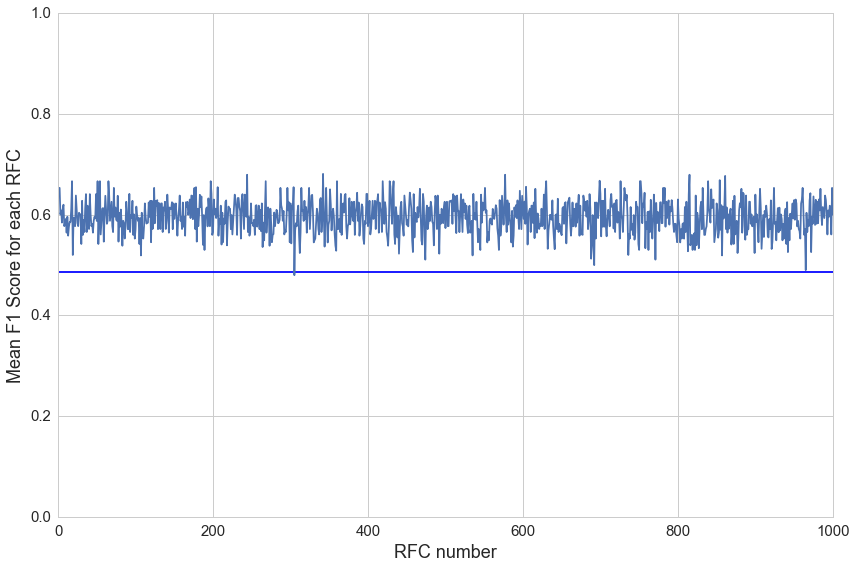

In [107]:
if not rerun:
    scores_range = pickle.load( open( "RFC_1000_runs_scores.p", "rb" ) )

print np.median(scores_range)
median_scores = []
runs = range(1,1001)
for i in runs:
    median_scores.append(np.median(scores_range[i-1]))

plt.figure(figsize=(12,8))
plt.ylabel('Mean F1 Score for each RFC',fontsize=18)
plt.xlabel('RFC number',fontsize=18)
plt.axhline(y=F1_random)
plt.plot(runs,median_scores)
plt.ylim(ymax = 1, ymin = 0)
plt.tick_params(axis='both', which='major', labelsize=15)   
plt.show()


<type 'list'>


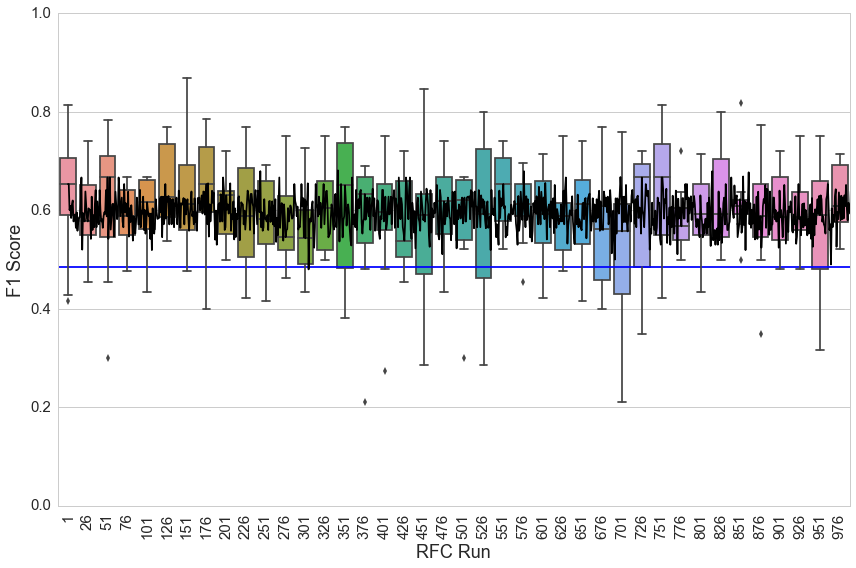

In [106]:
if not rerun:
    scores_range = pickle.load( open( "RFC_1000_runs_scores.p", "rb" ) )

#fig, ax = plt.subplots()
scores_trunc = scores_range[0::25]
test_labels = range(1,1001,25)
plt.figure(figsize=(12,8))
#plt.title('Effect of the number of trees on predictions', fontsize=20)
plt.xlabel('RFC Run', fontsize=18)
plt.ylabel('F1 Score', fontsize=18)
plt.ylim(ymax = 1, ymin = 0)
plt.xlim(xmax = 1000, xmin = 0)
plt.axhline(y=F1_random)
plt.tick_params(axis='both', which='major', labelsize=15)   
sns.set_style("whitegrid")
ax=sns.boxplot(x=test_labels,y=scores_trunc)
labels = ax.get_xticklabels()
for label in labels:
    label.set_rotation(90)
#plt.savefig('/Users/nschanch/Desktop/REU_2015/ipython_figures/forests_with_1_to_40_trees.png')
#sns.boxplot(scores) #NOTE: Use this line if you have the older version of seaborn!!
#plt.savefig("/home/nschanch/Downloads/test_img.png")
#Note: This is before correcting for the unbalanced sample size. 
print type(scores_range)

runs = np.arange(0, 40, 0.04)

ax=plt.plot(runs,median_scores,c='0.0')

plt.savefig('/storage/kreeves/Projects/REU/reu2015/final/Filament_tracking/RFC_runs_boxplot.eps')
plt.savefig('/storage/kreeves/Projects/REU/reu2015/final/Filament_tracking/RFC_runs_boxplot.pdf')
plt.savefig('/storage/kreeves/Projects/REU/reu2015/final/Filament_tracking/RFC_runs_boxplot.jpg')

plt.show()

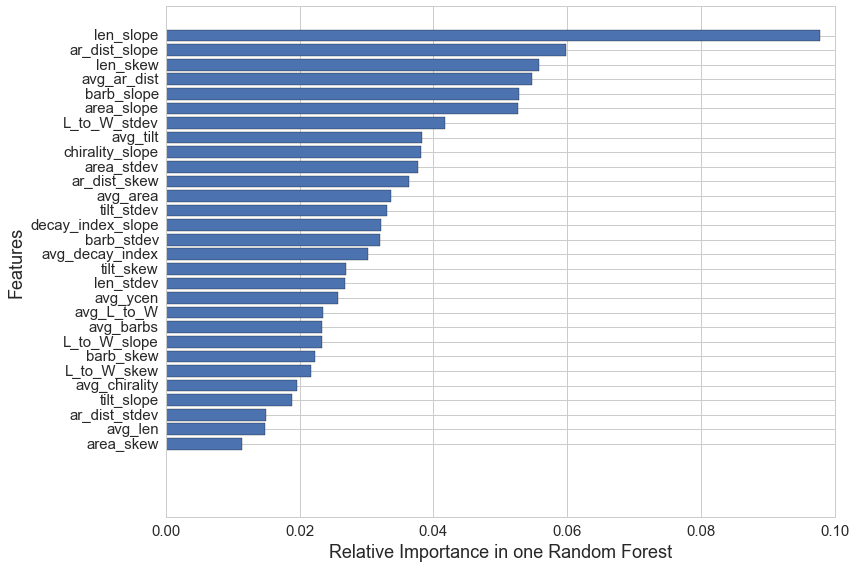

In [77]:
#takes last forest from run above and plots importances
if not rerun:
    importance_list = pickle.load( open( "RFC_1000_runs_importance_last.p", "rb" ) )

importance_list, name_list = zip(*sorted(zip(importance_list, name_list)))
plt.figure(figsize=(12,8))
plt.barh(range(len(name_list)),importance_list,align='center')
plt.yticks(range(len(name_list)),name_list)
plt.xlabel('Relative Importance in one Random Forest',fontsize=18)
plt.ylabel('Features',fontsize=18)
plt.tick_params(axis='both', which='major', labelsize=15)
#plt.title('Relative Importance of Each Feature for 1 Forest (depth = 5)',fontsize=20)
plt.savefig('/storage/kreeves/Projects/REU/reu2015/final/Filament_tracking/feature_importances_limited.eps')
plt.savefig('/storage/kreeves/Projects/REU/reu2015/final/Filament_tracking/feature_importances_limited.pdf')
plt.show()

/usr/local/anaconda/lib/python2.7/site-packages/seaborn/categorical.py:2171: UserWarning: The boxplot API has been changed. Attempting to adjust your arguments for the new API (which might not work). Please update your code. See the version 0.6 release notes for more info.
  warnings.warn(msg, UserWarning)


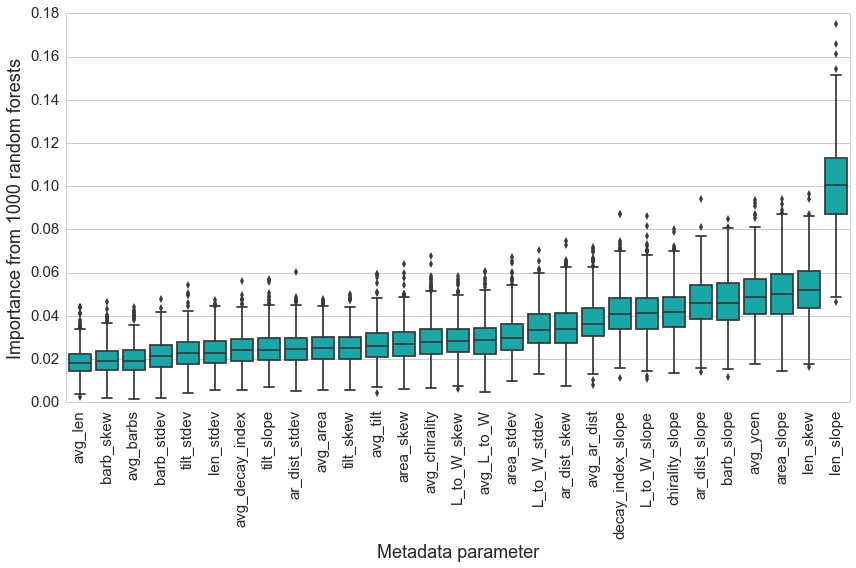

In [78]:
if not rerun:
    importances = pickle.load( open( "RFC_1000_runs_importances.p", "rb" ) )

#Transpose dataframe for use with boxplot
importances_trans = importances.T
importances_trans

#do this to put name_list in order of increasing mean
mean_importance = importances['mean']
name_list = mean_importance.index
mean_importance, name_list = zip(*sorted(zip(mean_importance, name_list)))
mean_importance_series = pd.Series(mean_importance, index=name_list)
name_list = mean_importance_series.index

plt.figure(figsize=(12,8))
plt.xlabel('Metadata parameter', fontsize=18)
plt.ylabel('Importance from 1000 random forests',fontsize=18)
plt.tight_layout()

sns.set_style("whitegrid")
ax=sns.boxplot(importances_trans, color="c", order=name_list)
labels = ax.get_xticklabels()
for label in labels:
    label.set_rotation(90) 
for tick in ax.xaxis.get_major_ticks():
                tick.label.set_fontsize(15)   
for tick in ax.yaxis.get_major_ticks():
                tick.label.set_fontsize(15)        
plt.savefig('/storage/kreeves/Projects/REU/reu2015/final/Filament_tracking/mean_importances_boxplot.eps')
plt.savefig('/storage/kreeves/Projects/REU/reu2015/final/Filament_tracking/mean_importances_boxplot.pdf')
plt.show()

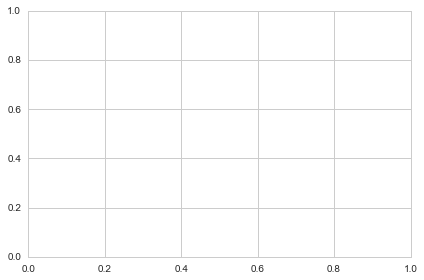

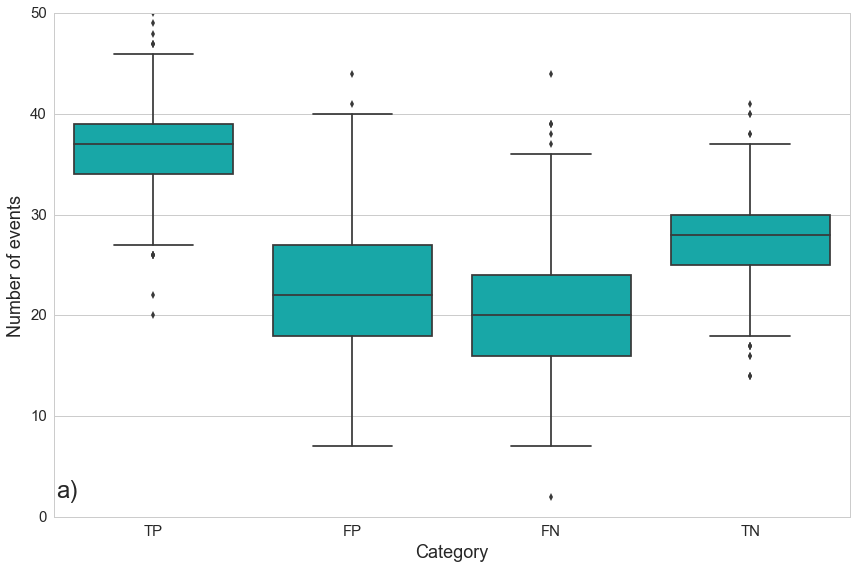

In [79]:
#Make box and whisker plot for confusion matrix

if not rerun:
    TP_array = pickle.load( open( "RFC_1000_runs_TP.p", "rb" ) )
    FP_array = pickle.load( open( "RFC_1000_runs_FP.p", "rb" ) )
    FN_array = pickle.load( open( "RFC_1000_runs_FN.p", "rb" ) )
    TN_array = pickle.load( open( "RFC_1000_runs_TN.p", "rb" ) )


cf_matrix_stats = pd.DataFrame.from_items([('TP', TP_array), ('FP', FP_array),('FN',FN_array),('TN', TN_array)])    

fig, ax = plt.subplots()

plt.figure(figsize=(12,8))
sns.boxplot(cf_matrix_stats, color="c", order=cf_matrix_stats.columns)
plt.tick_params(axis='both', which='major', labelsize=15)       
plt.xlabel('Category', fontsize=18)
plt.ylabel('Number of events',fontsize=18)      

plt.text(0.05,0.15,'a)',fontsize=24,transform=ax.transAxes)
plt.savefig('/storage/kreeves/Projects/REU/reu2015/final/Filament_tracking/mean_confusion_elements.eps')
plt.savefig('/storage/kreeves/Projects/REU/reu2015/final/Filament_tracking/mean_confusion_elements.pdf')

plt.show() 

0.601822429907


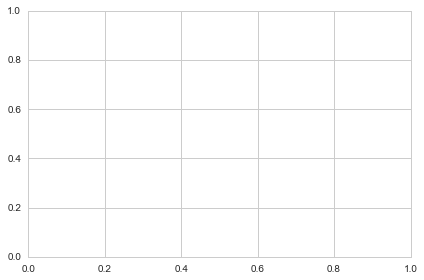

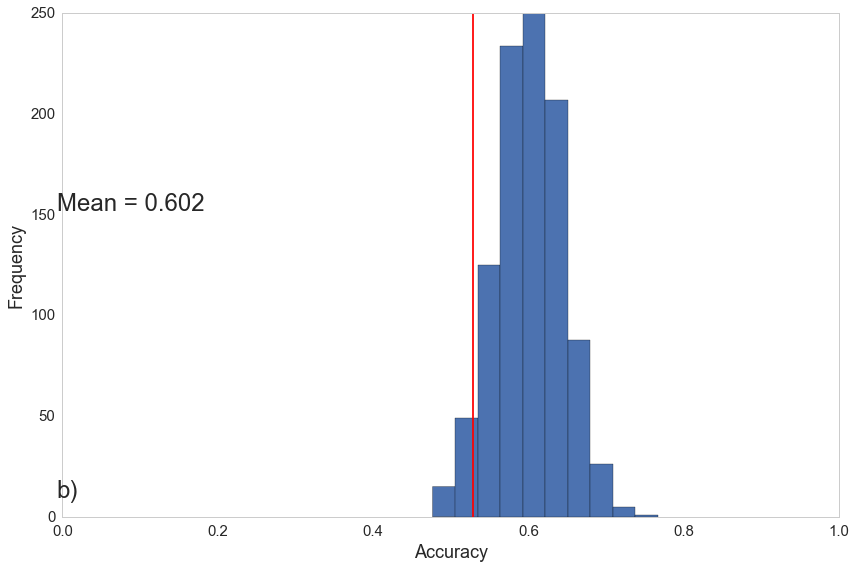

In [80]:
if not rerun:
    accuracy_array = pickle.load( open( "RFC_1000_runs_accuracy.p", "rb" ) )

print np.mean(accuracy_array)

mean = round(np.mean(accuracy_array),3)
fig, ax = plt.subplots()
plt.figure(figsize=(12,8))

plt.hist(accuracy_array)
plt.xlim(xmax = 1, xmin = 0)
#plt.title("Accuracy Histogram")
plt.xlabel("Accuracy", fontsize=18)
plt.ylabel("Frequency", fontsize=18)
plt.axvline(x=avg,color='r')
plt.text(0.05,0.15,'b)',fontsize=24,transform=ax.transAxes)
plt.text(0.05,1.2,'Mean = %s'%mean,fontsize=24,transform=ax.transAxes)
plt.tick_params(axis='both', which='major', labelsize=15)
plt.grid(False)
plt.savefig('/storage/kreeves/Projects/REU/reu2015/final/Filament_tracking/accuracy_histogram.eps')
plt.savefig('/storage/kreeves/Projects/REU/reu2015/final/Filament_tracking/accuracy_histogram.pdf')
plt.show()

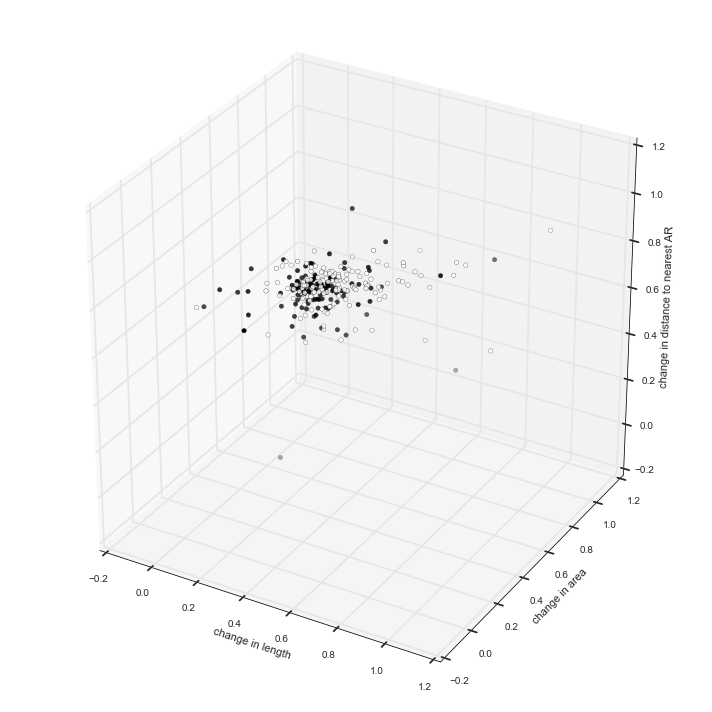

In [81]:
from mpl_toolkits.mplot3d import Axes3D

colors=Y

fig = plt.figure(figsize=(10,10))
ax = fig.add_subplot(111, projection='3d')

#for c, m, zl, zh in [('r', 'o', -50, -25), ('b', '^', -30, -5)]:
#    xs = randrange(n, 23, 32)
#    ys = randrange(n, 0, 100)
#    zs = randrange(n, zl, zh)
ax.scatter(good_eruptions['len_slope'], good_eruptions['area_slope'], good_eruptions['ar_dist_slope'], c=colors)

ax.set_xlabel('change in length')
ax.set_ylabel('change in area')
ax.set_zlabel('change in distance to nearest AR')

plt.show()

## This section just makes a png with an example single decision tree

In [82]:
# taken from http://chrisstrelioff.ws/sandbox/2015/06/08/decision_trees_in_python_with_scikit_learn_and_pandas.html
def visualize_tree(tree, feature_names):
    """Create tree ps using graphviz.

    Args
    ----
    tree -- scikit-learn DecsisionTree.
    feature_names -- list of feature names.
    """
    with open("test_tree.dot", 'w') as f:
        export_graphviz(tree, out_file=f,
                        feature_names=feature_names)

    command = ["dot", "-Tps2", "test_tree.dot", "-o", "test_tree.eps"]
    try:
        #os.popen(command)
        #You will need to install graphviz in order to do this. 
        subprocess.check_call(command)
    except:
        exit("Could not run dot, ie graphviz, to "
             "produce visualization")

In [83]:
#OK, now I want to try to visualize a single decision tree and break down the splits that are made
from sklearn.tree import DecisionTreeClassifier, export_graphviz
import subprocess

single_tree = DecisionTreeClassifier(max_depth=5)
single_tree.fit(X_2, Y)

DecisionTreeClassifier(class_weight=None, criterion='gini', max_depth=5,
            max_features=None, max_leaf_nodes=None, min_samples_leaf=1,
            min_samples_split=2, min_weight_fraction_leaf=0.0,
            presort=False, random_state=None, splitter='best')

In [84]:
visualize_tree(single_tree, name_list)

## Cumulative distribution functions

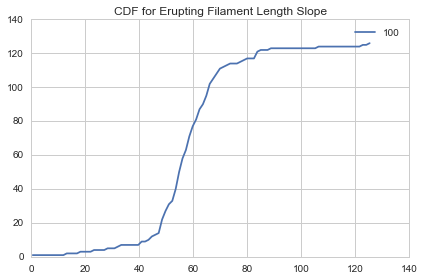

In [85]:
#This is all just copied from what Ashna did in the original filament_statistics notebook
from __future__ import division
import numpy as np
from scipy.stats import cumfreq
import pylab as plt
erupt_slen_data = erupting['len_slope']
sorted_erupt_slen = np.sort(erupt_slen_data)
#cumulative = np.cumsum(sorted_erupt_slen)

#plt.plot(cumulative, 'o')
#plt.show()

hi = len(erupt_slen_data)
a = sorted_erupt_slen
for nbins in (2, 20, 100):
    cf = cumfreq(a, nbins)  # bin values, lowerlimit, binsize, extrapoints
    w = hi / nbins
    x = np.linspace( w/2, hi - w/2, nbins )  # care
    # print x, cf
plt.plot( x, cf[0], label=str(nbins) )
plt.title('CDF for Erupting Filament Length Slope')
plt.legend()
plt.show()

In [86]:
def cumulativedistribution(eruptingdata, noneruptingdata,feature,xlabel, ax, xlims, ylims):
    sorted_val=np.sort(eruptingdata.tolist())
    yvals=np.arange(len(sorted_val))/float(len(sorted_val))
    #ax = fig.add_axes([0,0,1,1])
    erupt_cdf = ax.plot( sorted_val, yvals,color='0.7', label='erupting')

    pvalue = ad_siglevel_series[feature]
    Asquared = ad_stat_series[feature]
    
    sorted_val=np.sort(noneruptingdata.tolist())
    yvals=np.arange(len(sorted_val))/float(len(sorted_val))
    non_cdf = ax.plot( sorted_val, yvals,color='black' , label='non-erupting')
    plt.legend(loc='upper left', fontsize=15)
    #plt.title('CDF for %s'%feature)
    plt.xlabel('%s' %xlabel, fontsize=18)
    plt.ylabel('Cumulative Probability',fontsize=18)    
    plt.tick_params(axis='both', which='major', labelsize=15)
    if feature == 'len_slope':
        plt.text(0.5,0.1,'p-value = %.2g'%pvalue,fontsize=14,transform=ax.transAxes)
    else:
        plt.text(0.5,0.1,'p-value = %.3g'%pvalue,fontsize=14,transform=ax.transAxes)
    
    plt.text(0.5,0.15,'A$^2$ = %.2f'%Asquared,fontsize=14,transform=ax.transAxes)
    
    ax.set_xlim(xlims)
    ax.set_ylim(ylims)
    return ax

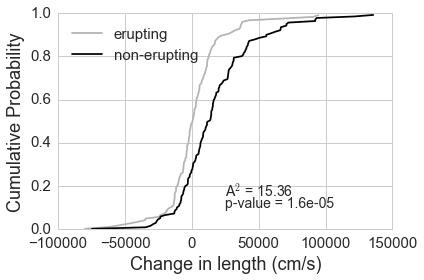

In [87]:
fig, ax = plt.subplots()
xlims = (-100000, 150000)
ylims = (0, 1)
cumulativedistribution(erupting['len_slope'], non_erupting['len_slope'], 'len_slope', 'Change in length (cm/s)',
                       ax,xlims,ylims)
plt.savefig('/Volumes/kathy/Backscratch/kreeves/Projects/REU/reu2015/final/Filament_tracking/CDF_length_slope.eps')
plt.show()

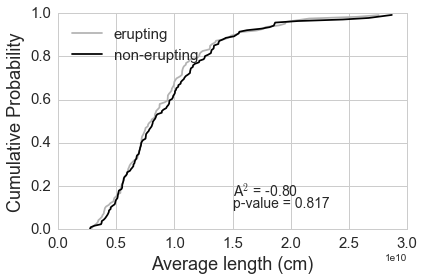

In [88]:
fig, ax = plt.subplots()
xlims = (0, 30000000000)
ylims = (0, 1)
cumulativedistribution(erupting['avg_len'], non_erupting['avg_len'], 'avg_len','Average length (cm)',
                      ax,xlims,ylims)

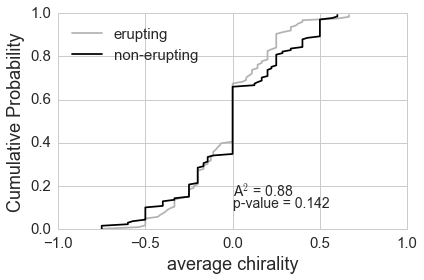

In [89]:
fig, ax = plt.subplots()
xlims = (-1, 1)
ylims = (0, 1)
cumulativedistribution(erupting['avg_chirality'], non_erupting['avg_chirality'], 'avg_chirality','average chirality',
                      ax,xlims,ylims)

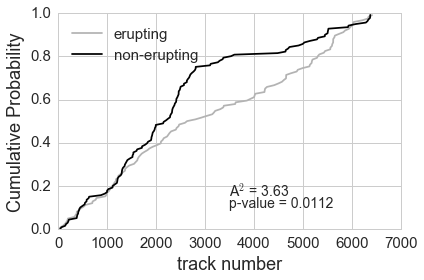

In [90]:
fig, ax = plt.subplots()
xlims = (0, 7000)
ylims = (0, 1)
cumulativedistribution(erupting['Track No.'], non_erupting['Track No.'],'Track No.', 'track number',
                      ax,xlims,ylims)

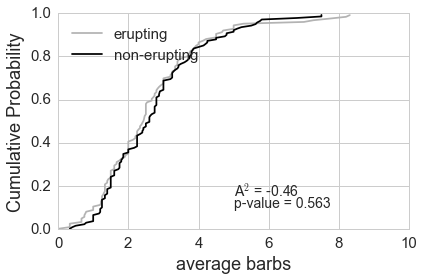

In [91]:
fig, ax = plt.subplots()
xlims = (0, 10)
ylims = (0, 1)
cumulativedistribution(erupting['avg_barbs'], non_erupting['avg_barbs'], 'avg_barbs','average barbs',
                      ax,xlims,ylims)
plt.savefig('/Volumes/kathy/Backscratch/kreeves/Projects/REU/reu2015/final/Filament_tracking/CDF_avg_barbs.eps')
plt.show()

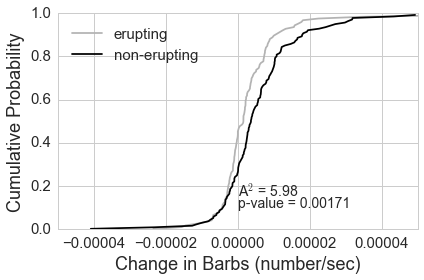

In [92]:
fig, ax = plt.subplots()
xlims = (-0.00005,0.00005)
ylims = (0, 1)
cumulativedistribution(erupting['barb_slope'], non_erupting['barb_slope'], 'barb_slope','Change in Barbs (number/sec)',
                      ax,xlims,ylims)
plt.show()

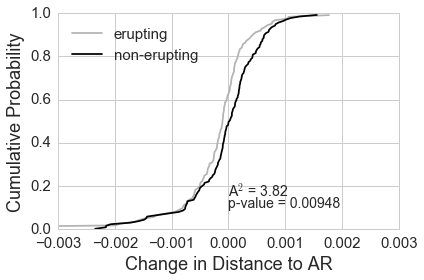

In [93]:
fig, ax = plt.subplots()
xlims = (-0.003,0.003)
ylims = (0, 1)
cumulativedistribution(erupting['ar_dist_slope'], non_erupting['ar_dist_slope'], 'ar_dist_slope','Change in Distance to AR',
                      ax,xlims,ylims)
plt.show()

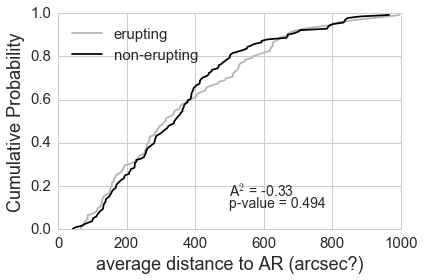

In [94]:
fig, ax = plt.subplots()
xlims = (0, 1000)
ylims = (0, 1)
cumulativedistribution(erupting['avg_ar_dist'], non_erupting['avg_ar_dist'], 'avg_ar_dist',
                       'average distance to AR (arcsec?)',ax,xlims,ylims)

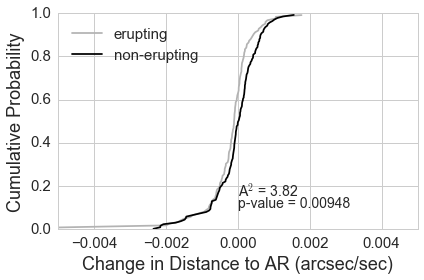

In [95]:
fig, ax = plt.subplots()
xlims = (-0.005, 0.005)
ylims = (0, 1)
cumulativedistribution(erupting['ar_dist_slope'], non_erupting['ar_dist_slope'], 'ar_dist_slope',
                       'Change in Distance to AR (arcsec/sec)',ax,xlims,ylims)

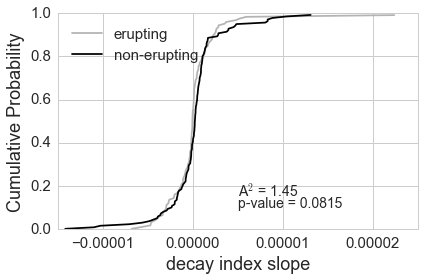

In [96]:
fig, ax = plt.subplots()
xlims = (-0.000015,0.000025)
ylims = (0, 1)
cumulativedistribution(erupting['decay_index_slope'], non_erupting['decay_index_slope'],'decay_index_slope', 
                       'decay index slope',ax,xlims, ylims)

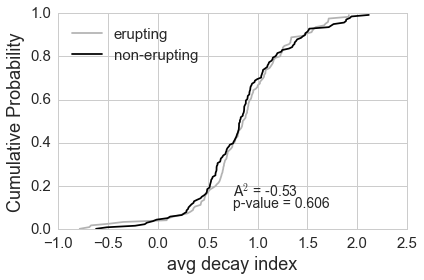

In [97]:
fig, ax = plt.subplots()
xlims = (-1,2.5)
ylims = (0, 1)
cumulativedistribution(erupting['avg_decay_index'], non_erupting['avg_decay_index'], 'avg_decay_index',
                       'avg decay index',ax,xlims, ylims)
plt.savefig('/Volumes/kathy/Backscratch/kreeves/Projects/REU/reu2015/final/Filament_tracking/CDF_avg_devcay_index.eps')
plt.show()

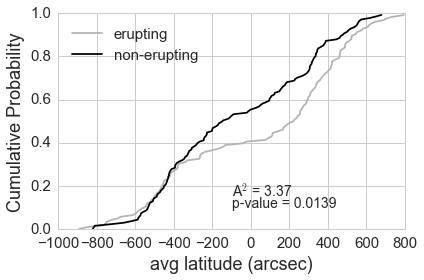

In [98]:
fig, ax = plt.subplots()
ylims = (0, 1)
xlims = (-1000, 800)
cumulativedistribution(erupting['avg_ycen'], non_erupting['avg_ycen'], 'avg_ycen','avg latitude (arcsec)',
                       ax,xlims, ylims)
plt.savefig('/Volumes/kathy/Backscratch/kreeves/Projects/REU/reu2015/final/Filament_tracking/CDF_avg_latitude.eps')
plt.show()

In [99]:
def stylize_axes(ax, xlabel, ylabel):
    ax.set_xlabel(xlabel,fontsize=18)
    ax.set_ylabel(ylabel,fontsize=18)
    
    ax.xaxis.set_tick_params(which='major', labelsize=15)
    ax.yaxis.set_tick_params(which='major', labelsize=15)
    
    ax.legend(loc='upper left', fontsize=15)

/usr/local/anaconda/lib/python2.7/site-packages/matplotlib/axes/_axes.py:519: UserWarning: No labelled objects found. Use label='...' kwarg on individual plots.
  warnings.warn("No labelled objects found. "


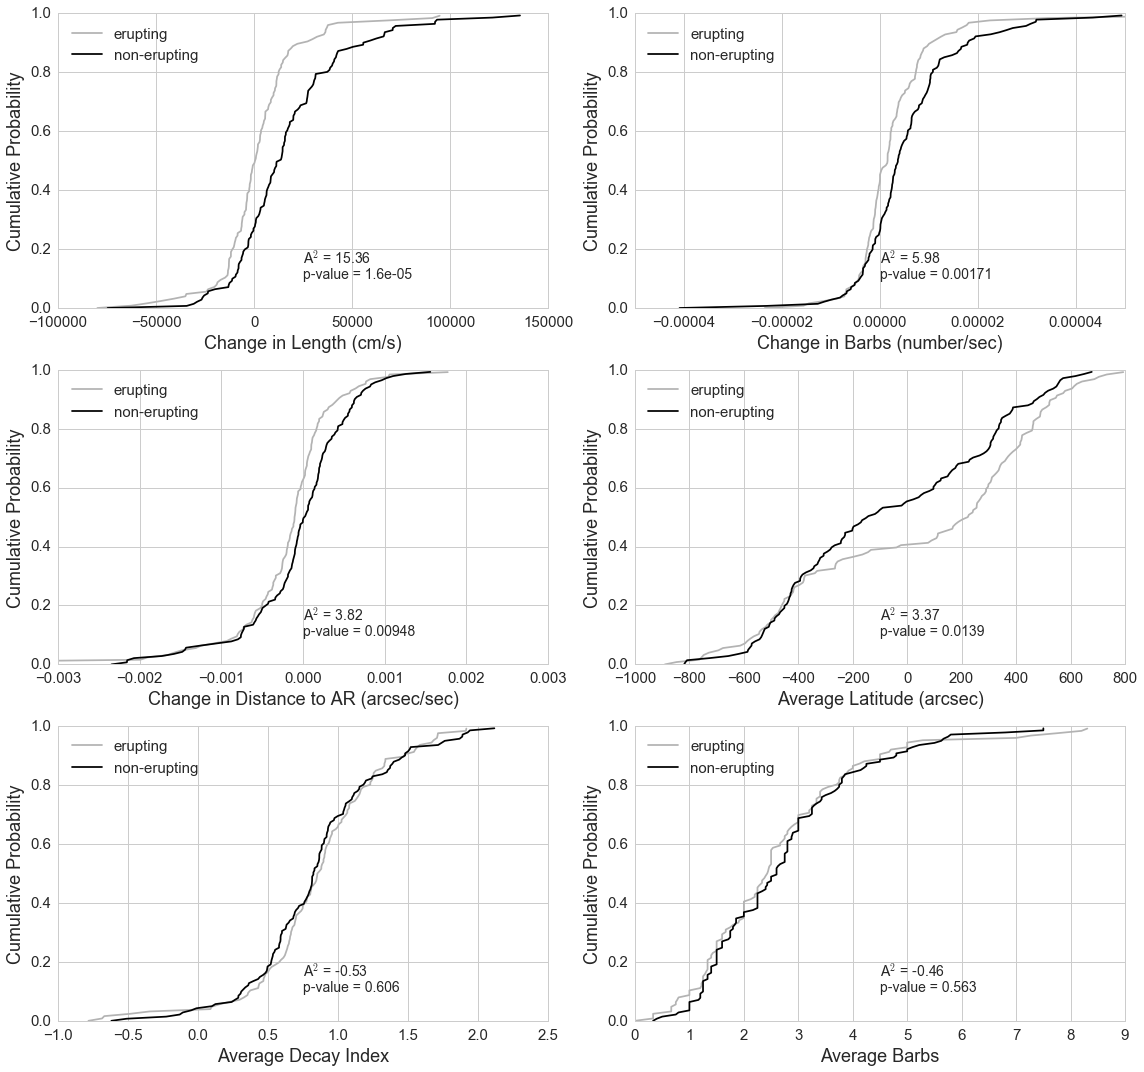

In [100]:
fig, ax = plt.subplots(nrows=3, ncols=2, figsize=(16,15))
ylims = (0, 1)

xlims = (-100000, 150000)
cumulativedistribution(erupting['len_slope'], non_erupting['len_slope'], 'len_slope','Change in length (cm/s)',
                       ax[0][0],xlims,ylims)
xlims = (-0.00005,0.00005)
cumulativedistribution(erupting['barb_slope'], non_erupting['barb_slope'], 'barb_slope','Change in Barbs (number/sec)',
                      ax[0][1],xlims,ylims)

xlims = (-0.003,0.003)
cumulativedistribution(erupting['ar_dist_slope'], non_erupting['ar_dist_slope'], 'ar_dist_slope','Change in Distance to AR',
                      ax[1][0],xlims,ylims)

xlims = (-1000, 800)
cumulativedistribution(erupting['avg_ycen'], non_erupting['avg_ycen'], 'avg_ycen','Average latitude (arcsec)',
                       ax[1][1],xlims,ylims)
xlims = (-1, 2.5)
cumulativedistribution(erupting['avg_decay_index'], non_erupting['avg_decay_index'], 'avg_decay_index',
                       'Average decay index',ax[2][0],xlims,ylims)
xlims = (0, 9)
cumulativedistribution(erupting['avg_barbs'], non_erupting['avg_barbs'], 'avg_barbs','average barbs',ax[2][1],
                       xlims,ylims)

xlabel = ['Change in Length (cm/s)','Change in Barbs (number/sec)','Change in Distance to AR (arcsec/sec)',
          'Average Latitude (arcsec)','Average Decay Index','Average Barbs']
ylabel = 'Cumulative Probability'
for i, axes in enumerate(ax.flat):
    stylize_axes(axes,xlabel[i], ylabel)

plt.savefig('/Volumes/kathy/Backscratch/kreeves/Projects/REU/reu2015/final/Filament_tracking/CDF_multiplot.eps')
plt.savefig('/Volumes/kathy/Backscratch/kreeves/Projects/REU/reu2015/final/Filament_tracking/CDF_multiplot.pdf')
plt.show()    
    

In [101]:
def parameter_histograms(eruptingdata, noneruptingdata,feature,xlabel, ax, xlims, ylims,add_label):
    vals = eruptingdata.tolist()
    er_mean = np.mean(vals)
    num_bins=20
    erupt_hist = ax.hist(vals, num_bins, label='erupting',alpha=1)

    vals = noneruptingdata.tolist()
    non_mean = np.mean(vals)
    non_hist = ax.hist(vals, num_bins, label='non-erupting',alpha=0.7)
#    if add_label:
#        plt.legend(loc='upper left', fontsize=15)
    plt.xlabel('%s' %xlabel, fontsize=18)
    plt.ylabel('Frequency',fontsize=18)    
    plt.tick_params(axis='both', which='major', labelsize=15)
    plt.text(0.8,0.9,'mean = %.2g'%er_mean,fontsize=14,transform=ax.transAxes,color='blue') 
    plt.text(0.8,0.85,'mean = %.2g'%non_mean,fontsize=14,transform=ax.transAxes,color='green') 
    
    ax.set_xlim(xlims)
#    ax.set_ylim(ylims)
    return ax

(array([  1.,   0.,   0.,   0.,   0.,   1.,   0.,   0.,   0.,   0.,   0.,
          2.,   5.,   4.,  20.,  55.,  27.,   8.,   2.,   1.]),
 array([ -6.82902300e-03,  -6.39901765e-03,  -5.96901230e-03,
         -5.53900695e-03,  -5.10900160e-03,  -4.67899625e-03,
         -4.24899090e-03,  -3.81898555e-03,  -3.38898020e-03,
         -2.95897485e-03,  -2.52896950e-03,  -2.09896415e-03,
         -1.66895880e-03,  -1.23895345e-03,  -8.08948100e-04,
         -3.78942750e-04,   5.10626000e-05,   4.81067950e-04,
          9.11073300e-04,   1.34107865e-03,   1.77108400e-03]),
 <a list of 20 Patch objects>)

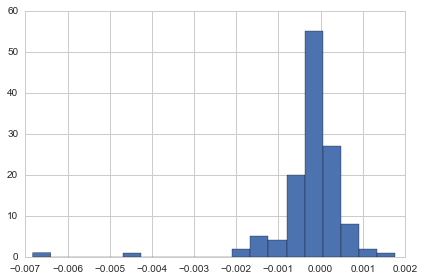

In [102]:
eruptingdata = erupting['ar_dist_slope']
vals = eruptingdata.tolist()
plt.hist(vals,20)

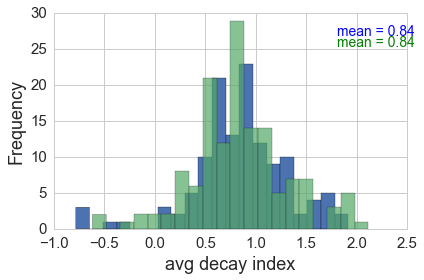

In [103]:
fig, ax = plt.subplots()
xlims = (-1,2.5)
ylims = (0, 100)
parameter_histograms(erupting['avg_decay_index'], non_erupting['avg_decay_index'], 'avg_decay_index',
                       'avg decay index',ax,xlims, ylims,add_label=False)

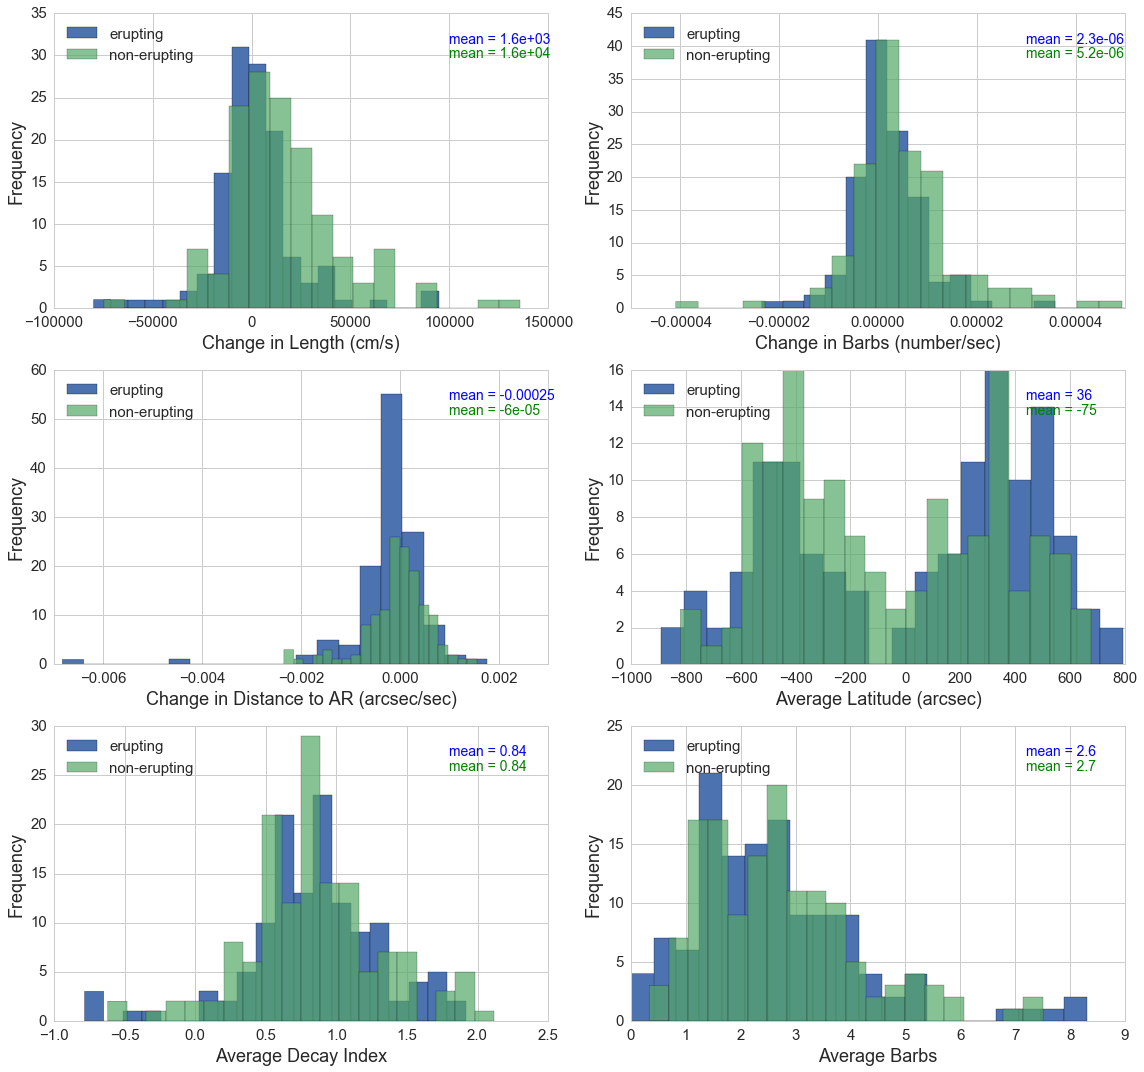

In [104]:
fig, ax = plt.subplots(nrows=3, ncols=2, figsize=(16,15))
ylims = (0, 1)

xlims = (-100000, 150000)
parameter_histograms(erupting['len_slope'], non_erupting['len_slope'], 'len_slope','Change in length (cm/s)',
                       ax[0][0],xlims,ylims,add_label=False)

xlims = (-0.00005,0.00005)
parameter_histograms(erupting['barb_slope'], non_erupting['barb_slope'], 'barb_slope','Change in Barbs (number/sec)',
                      ax[0][1],xlims,ylims,add_label=False)

xlims = (-0.007,0.003)
parameter_histograms(erupting['ar_dist_slope'], non_erupting['ar_dist_slope'], 'ar_dist_slope','Change in Distance to AR',
                      ax[1][0],xlims,ylims,add_label=False)

xlims = (-1000, 800)
parameter_histograms(erupting['avg_ycen'], non_erupting['avg_ycen'], 'avg_ycen','Average latitude (arcsec)',
                       ax[1][1],xlims,ylims,add_label=False)
xlims = (-1, 2.5)
parameter_histograms(erupting['avg_decay_index'], non_erupting['avg_decay_index'], 'avg_decay_index',
                       'Average decay index',ax[2][0],xlims,ylims,add_label=False)
xlims = (0, 9)
parameter_histograms(erupting['avg_barbs'], non_erupting['avg_barbs'], 'avg_barbs','average barbs',ax[2][1],
                       xlims,ylims,add_label=False)

xlabel = ['Change in Length (cm/s)','Change in Barbs (number/sec)','Change in Distance to AR (arcsec/sec)',
          'Average Latitude (arcsec)','Average Decay Index','Average Barbs']
ylabel = 'Frequency'
for i, axes in enumerate(ax.flat):
    stylize_axes(axes,xlabel[i], ylabel)

plt.savefig('/Volumes/kathy/Backscratch/kreeves/Projects/REU/reu2015/final/Filament_tracking/hist_multiplot.eps')
plt.savefig('/Volumes/kathy/Backscratch/kreeves/Projects/REU/reu2015/final/Filament_tracking/hist_multiplot.pdf')
plt.show() 

In [105]:
print erupting['ar_dist_slope']

0     -1.090000e-03
1     -7.840000e-05
2     -2.814120e-04
3      6.330000e-05
4     -4.840000e-07
5     -1.871120e-04
6      5.688860e-04
7     -4.498318e-03
8     -6.829023e-03
9     -1.188340e-04
10    -2.500100e-04
11    -1.659041e-03
12    -6.935520e-04
13    -1.187980e-04
14    -1.313658e-03
15     6.411980e-04
16     1.955000e-04
17     1.043116e-03
18    -5.780680e-04
19     2.445420e-04
20    -9.352520e-04
21    -1.060700e-04
22    -6.200000e-05
23     3.578000e-04
24    -2.562010e-04
25     5.720000e-05
26    -5.910520e-04
27     2.340000e-05
28    -1.999390e-04
29    -3.346860e-04
           ...     
96    -2.231570e-04
97     1.786170e-04
98    -4.327460e-04
99    -2.593600e-04
100   -9.670000e-05
101   -3.751480e-04
102   -1.252366e-03
103   -6.090000e-05
104    3.135940e-04
105   -1.526870e-04
106   -3.653600e-04
107   -1.052350e-04
108    2.640000e-05
109   -5.023620e-04
110    1.748080e-04
111   -2.682690e-04
112   -8.040000e-05
113   -8.710000e-05
114   -6.040360e-04
